# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook  - ***13 points***
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework) 
- homework_differentiation.ipynb -  ***2 points***

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
np.random.seed(42)

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

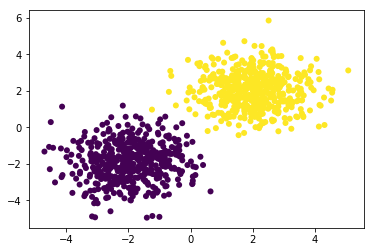

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()
print(net)

Linear 2 -> 2
LogSoftMax



Another test:

In [5]:
net = Sequential()
net.add(Linear(2, 8))
net.add(ReLU())
net.add(Linear(8, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()
print(net)

Linear 2 -> 8
ReLU
Linear 8 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

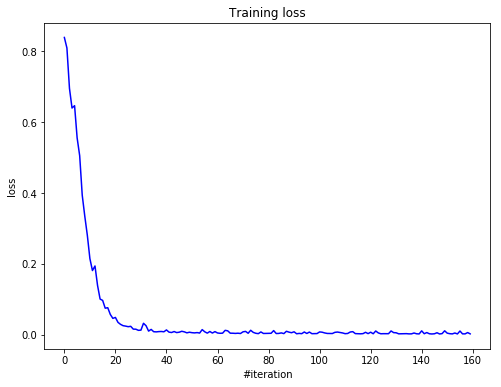

Iteration 19. Current loss: 0.002336669138644878


In [8]:
loss_history = []
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Iteration {}. Current loss: {}'.format(i, loss)) 

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [9]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [10]:
# Your code goes here. ################################################
def one_hot_encode(labels, class_number):
    return np.eye(class_number)[labels]

def get_accuracy(labels, preds):
    tmp_preds = np.argmax(preds, axis=1)
    preds_encoded = one_hot_encode(tmp_preds, 10)
    incorrect = (labels.size - (preds_encoded == labels).sum())/2
    return 1 - incorrect / labels.shape[0]
    

class_number = 10
y_train_orig = y_train.copy()
y_val_orig = y_val.copy()
y_test_orig = y_test.copy()
y_train = one_hot_encode(y_train, class_number)
y_val = one_hot_encode(y_val, class_number)
y_test = one_hot_encode(y_test, class_number)

X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison. Write your personal opinion on the activation functions, think about computation times too. Plot the losses both from activation functions comparison comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking. ***2.5 points***
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions. Plot the losses both for the `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.  Does `BatchNormalization` help? ***2.5 points***

- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better? ***2.5 points***
- Increase the number of parameters in the network. Try inserting the Dropout layer. Compare the validation performance and the gap between test and validation performances for the two experiments (with and without Dropout). Compare the loss plots. Which one converges slower? ***2.5 points***


1. **Comparing** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions

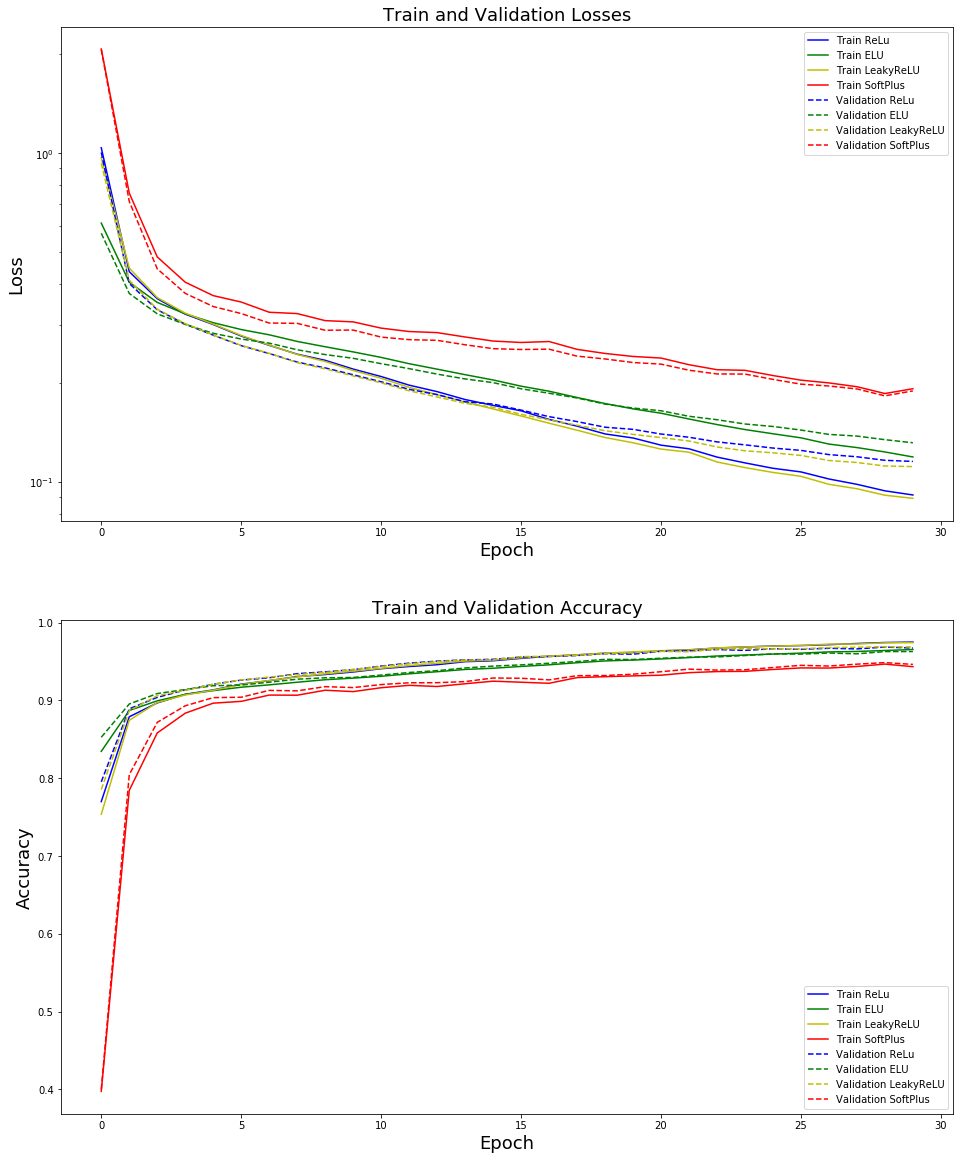

Epoch 30
Min train losses: ReLu 0.09122; ELU 0.1191; LeakyReLu 0.0891; SoftPlus 0.1857
Min val losses: ReLu 0.1154; ELU 0.1315; LeakyReLu 0.1113; SoftPlus 0.1827
Max train accuracy: ReLu 0.9749; ELU 0.9653; LeakyReLu 0.9741; SoftPlus 0.9466
Max val accuracy: ReLu 0.9685; ELU 0.9627; LeakyReLu 0.9689; SoftPlus 0.9485
Times: ReLu 38.28 sec; ELU 53.79 sec; LeakyReLu 50.17 sec; SoftPlus 39.71 sec


In [11]:
# Your code goes here. ################################################
relu_net = Sequential()
relu_net.add(Linear(X_train.shape[1], 100))
relu_net.add(ReLU())
relu_net.add(Linear(100, 200))
relu_net.add(ReLU())
relu_net.add(Linear(200, 10))
relu_net.add(LogSoftMax())
relu_criterion = ClassNLLCriterion()

elu_net = Sequential()
elu_net.add(Linear(X_train.shape[1], 100))
elu_net.add(ELU())
elu_net.add(Linear(100, 200))
elu_net.add(ELU())
elu_net.add(Linear(200, 10))
elu_net.add(LogSoftMax())
elu_criterion = ClassNLLCriterion()

leaky_relu_net = Sequential()
leaky_relu_net.add(Linear(X_train.shape[1], 100))
leaky_relu_net.add(LeakyReLU())
leaky_relu_net.add(Linear(100, 200))
leaky_relu_net.add(LeakyReLU())
leaky_relu_net.add(Linear(200, 10))
leaky_relu_net.add(LogSoftMax())
leaky_relu_criterion = ClassNLLCriterion()

soft_plus_net = Sequential()
soft_plus_net.add(Linear(X_train.shape[1], 100))
soft_plus_net.add(SoftPlus())
soft_plus_net.add(Linear(100, 200))
soft_plus_net.add(SoftPlus())
soft_plus_net.add(Linear(200, 10))
soft_plus_net.add(LogSoftMax())
soft_plus_criterion = ClassNLLCriterion()

relu_val_loss_history = []
elu_val_loss_history = []
leaky_relu_val_loss_history = []
soft_plus_val_loss_history = []

relu_train_loss_history = []
elu_train_loss_history = []
leaky_relu_train_loss_history = []
soft_plus_train_loss_history = []

relu_val_accuracy_history = []
elu_val_accuracy_history = []
leaky_relu_val_accuracy_history = []
soft_plus_val_accuracy_history = []

relu_train_accuracy_history = []
elu_train_accuracy_history = []
leaky_relu_train_accuracy_history = []
soft_plus_train_accuracy_history = []

relu_time = 0
elu_time = 0
leaky_relu_time = 0
soft_plus_time = 0

relu_optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
relu_optimizer_state = {}
elu_optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
elu_optimizer_state = {}
leaky_relu_optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
leaky_relu_optimizer_state = {}
soft_plus_optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
soft_plus_optimizer_state = {}

n_epoch = 30
batch_size = 500
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        relu_start_time = time()
        relu_net.zeroGradParameters()
        relu_predictions = relu_net.forward(x_batch)
        relu_loss = relu_criterion.forward(relu_predictions, y_batch)
        relu_dp = relu_criterion.backward(relu_predictions, y_batch)
        relu_net.backward(x_batch, relu_dp)
        sgd_momentum(relu_net.getParameters(), 
                     relu_net.getGradParameters(), 
                     relu_optimizer_config,
                     relu_optimizer_state)
        relu_stop_time = time()
        relu_time += relu_stop_time - relu_start_time
        
        elu_start_time = time()
        elu_net.zeroGradParameters()
        elu_predictions = elu_net.forward(x_batch)
        elu_loss = elu_criterion.forward(elu_predictions, y_batch)
        elu_dp = elu_criterion.backward(elu_predictions, y_batch)
        elu_net.backward(x_batch, elu_dp)
        sgd_momentum(elu_net.getParameters(), 
                     elu_net.getGradParameters(), 
                     elu_optimizer_config,
                     elu_optimizer_state)
        elu_stop_time = time()
        elu_time += elu_stop_time - elu_start_time
        
        leaky_relu_start_time = time()
        leaky_relu_net.zeroGradParameters()
        leaky_relu_predictions = leaky_relu_net.forward(x_batch)
        leaky_relu_loss = leaky_relu_criterion.forward(leaky_relu_predictions, y_batch)
        leaky_relu_dp = leaky_relu_criterion.backward(leaky_relu_predictions, y_batch)
        leaky_relu_net.backward(x_batch, leaky_relu_dp)
        sgd_momentum(leaky_relu_net.getParameters(), 
                     leaky_relu_net.getGradParameters(), 
                     leaky_relu_optimizer_config,
                     leaky_relu_optimizer_state)
        leaky_relu_stop_time = time()
        leaky_relu_time += leaky_relu_stop_time - leaky_relu_start_time
        
        soft_plus_start_time = time()
        soft_plus_net.zeroGradParameters()
        soft_plus_predictions = soft_plus_net.forward(x_batch)
        soft_plus_loss = soft_plus_criterion.forward(soft_plus_predictions, y_batch)
        soft_plus_dp = soft_plus_criterion.backward(soft_plus_predictions, y_batch)
        soft_plus_net.backward(x_batch, soft_plus_dp)
        sgd_momentum(soft_plus_net.getParameters(), 
                     soft_plus_net.getGradParameters(), 
                     soft_plus_optimizer_config,
                     soft_plus_optimizer_state)
        soft_plus_stop_time = time()
        soft_plus_time += soft_plus_stop_time - soft_plus_start_time

    # Validation scores and losses
    relu_val_predictions = relu_net.forward(X_val)
    relu_val_loss = relu_criterion.forward(relu_val_predictions, y_val)
    relu_val_accuracy = get_accuracy(y_val, relu_val_predictions)
    elu_val_predictions = elu_net.forward(X_val)
    elu_val_loss = elu_criterion.forward(elu_val_predictions, y_val)
    elu_val_accuracy = get_accuracy(y_val, elu_val_predictions)
    leaky_relu_val_predictions = leaky_relu_net.forward(X_val)
    leaky_relu_val_loss = leaky_relu_criterion.forward(leaky_relu_val_predictions, y_val)
    leaky_relu_val_accuracy = get_accuracy(y_val, leaky_relu_val_predictions)
    soft_plus_val_predictions = soft_plus_net.forward(X_val)
    soft_plus_val_loss = soft_plus_criterion.forward(soft_plus_val_predictions, y_val)
    soft_plus_val_accuracy = get_accuracy(y_val, soft_plus_val_predictions)
    
    relu_val_loss_history.append(relu_val_loss)
    elu_val_loss_history.append(elu_val_loss)
    leaky_relu_val_loss_history.append(leaky_relu_val_loss)
    soft_plus_val_loss_history.append(soft_plus_val_loss)
    
    relu_val_accuracy_history.append(relu_val_accuracy)
    elu_val_accuracy_history.append(elu_val_accuracy)
    leaky_relu_val_accuracy_history.append(leaky_relu_val_accuracy)
    soft_plus_val_accuracy_history.append(soft_plus_val_accuracy)
    
    #Train scores and losses
    relu_train_predictions = relu_net.forward(X_train)
    relu_train_loss = relu_criterion.forward(relu_train_predictions, y_train)
    relu_train_accuracy = get_accuracy(y_train, relu_train_predictions)
    elu_train_predictions = elu_net.forward(X_train)
    elu_train_loss = elu_criterion.forward(elu_train_predictions, y_train)
    elu_train_accuracy = get_accuracy(y_train, elu_train_predictions)
    leaky_relu_train_predictions = leaky_relu_net.forward(X_train)
    leaky_relu_train_loss = leaky_relu_criterion.forward(leaky_relu_train_predictions, y_train)
    leaky_relu_train_accuracy = get_accuracy(y_train, leaky_relu_train_predictions)
    soft_plus_train_predictions = soft_plus_net.forward(X_train)
    soft_plus_train_loss = soft_plus_criterion.forward(soft_plus_train_predictions, y_train)
    soft_plus_train_accuracy = get_accuracy(y_train, soft_plus_train_predictions)
    
    relu_train_loss_history.append(relu_train_loss)
    elu_train_loss_history.append(elu_train_loss)
    leaky_relu_train_loss_history.append(leaky_relu_train_loss)
    soft_plus_train_loss_history.append(soft_plus_train_loss)
    
    relu_train_accuracy_history.append(relu_train_accuracy)
    elu_train_accuracy_history.append(elu_train_accuracy)
    leaky_relu_train_accuracy_history.append(leaky_relu_train_accuracy)
    soft_plus_train_accuracy_history.append(soft_plus_train_accuracy)
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(16, 20))
    plt.subplot(2, 1, 1)
    plt.title("Train and Validation Losses", fontsize=18)
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Loss", fontsize=18)
    plt.semilogy(relu_train_loss_history, 'b', label='Train ReLu')
    plt.semilogy(elu_train_loss_history, 'g', label='Train ELU')
    plt.semilogy(leaky_relu_train_loss_history, 'y', label='Train LeakyReLU')
    plt.semilogy(soft_plus_train_loss_history, 'r', label='Train SoftPlus')
    plt.semilogy(relu_val_loss_history, 'b', label='Validation ReLu', linestyle='--')
    plt.semilogy(elu_val_loss_history, 'g', label='Validation ELU', linestyle='--')
    plt.semilogy(leaky_relu_val_loss_history, 'y', label='Validation LeakyReLU', linestyle='--')
    plt.semilogy(soft_plus_val_loss_history, 'r', label='Validation SoftPlus', linestyle='--')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.title("Train and Validation Accuracy", fontsize=18)
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Accuracy", fontsize=18)
    plt.plot(relu_train_accuracy_history, 'b', label='Train ReLu')
    plt.plot(elu_train_accuracy_history, 'g', label='Train ELU')
    plt.plot(leaky_relu_train_accuracy_history, 'y', label='Train LeakyReLU')
    plt.plot(soft_plus_train_accuracy_history, 'r', label='Train SoftPlus')
    plt.plot(relu_val_accuracy_history, 'b', label='Validation ReLu', linestyle='--')
    plt.plot(elu_val_accuracy_history, 'g', label='Validation ELU', linestyle='--')
    plt.plot(leaky_relu_val_accuracy_history, 'y', label='Validation LeakyReLU', linestyle='--')
    plt.plot(soft_plus_val_accuracy_history, 'r', label='Validation SoftPlus', linestyle='--')
    plt.legend()
    plt.show()
    
    print('Epoch {}'.format(i+1))
    print('Min train losses: ReLu {:.4}; ELU {:.4}; LeakyReLu {:.4}; SoftPlus {:.4}'.
          format(min(relu_train_loss_history), min(elu_train_loss_history), 
                 min(leaky_relu_train_loss_history), min(soft_plus_train_loss_history)))
    print('Min val losses: ReLu {:.4}; ELU {:.4}; LeakyReLu {:.4}; SoftPlus {:.4}'.
          format(min(relu_val_loss_history), min(elu_val_loss_history), 
                 min(leaky_relu_val_loss_history), min(soft_plus_val_loss_history)))
    print('Max train accuracy: ReLu {:.4}; ELU {:.4}; LeakyReLu {:.4}; SoftPlus {:.4}'.
          format(max(relu_train_accuracy_history), max(elu_train_accuracy_history), 
                 max(leaky_relu_train_accuracy_history), max(soft_plus_train_accuracy_history))) 
    print('Max val accuracy: ReLu {:.4}; ELU {:.4}; LeakyReLu {:.4}; SoftPlus {:.4}'.
          format(max(relu_val_accuracy_history), max(elu_val_accuracy_history), 
                 max(leaky_relu_val_accuracy_history), max(soft_plus_val_accuracy_history)))
    print('Times: ReLu {:.4} sec; ELU {:.4} sec; LeakyReLu {:.4} sec; SoftPlus {:.4} sec'.
          format(relu_time, elu_time, leaky_relu_time, soft_plus_time))

Both activation functions ReLu and LeakyReLu performed quite similarly well. ELU was a little worse than these two but stil showed rather good convergency. However ReLu has the smallest computation time (and this is quite natural as it has the simplest structure and requires the smallest number of operations).

SoftPlus showed the worst convergency and the worst accuracy on both train and validation.

So for the next tasks I took ReLu as activation function.

2. **Inserting**  `BatchNormalization`

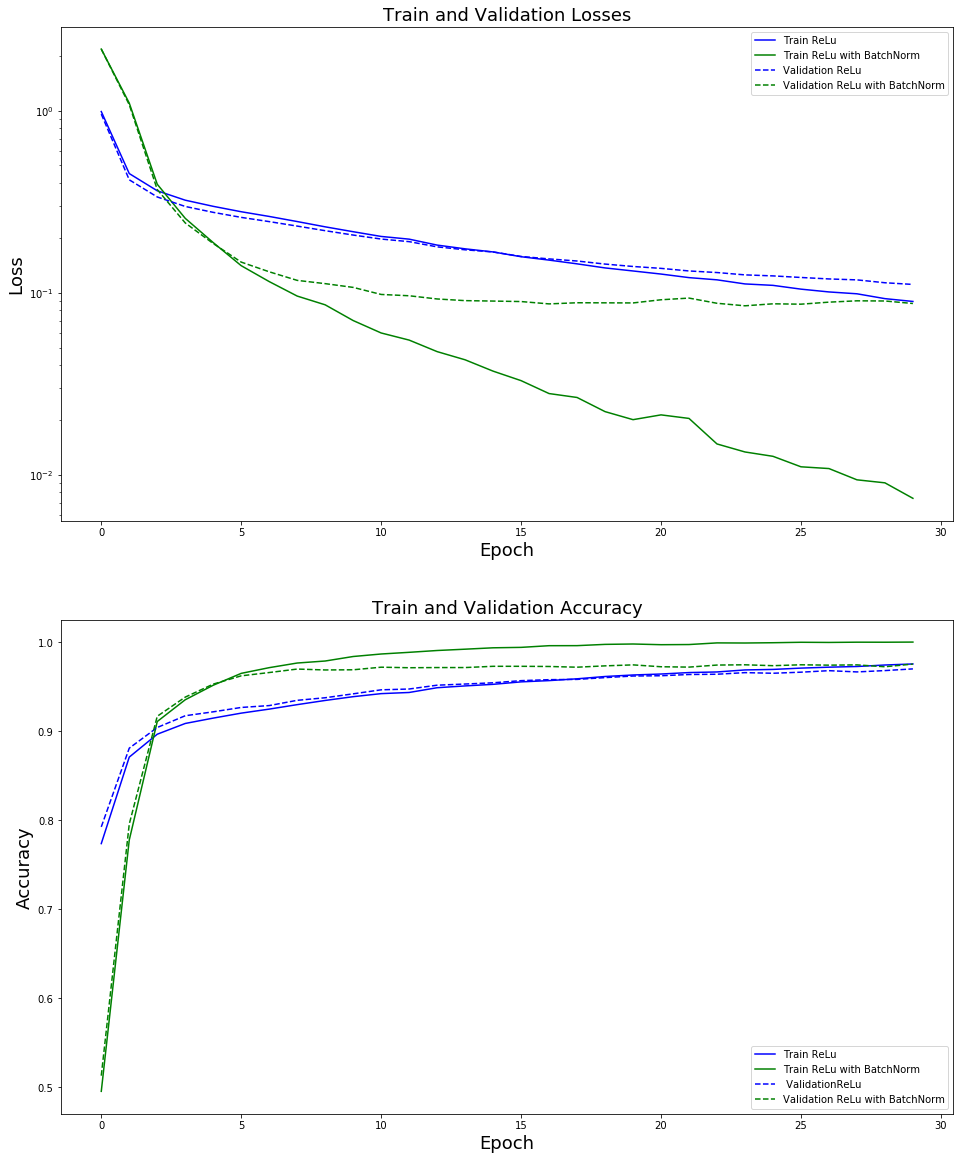

Epoch 30
Min train losses: ReLu 0.08956; BatchNorm 0.007426
Min val losses: ReLu 0.1111; BatchNorm 0.08476
Max train accuracy: ReLu 0.9752; BatchNorm 0.9998
Max val accuracy: ReLu 0.9697; BatchNorm 0.9751
Times: ReLu 37.14 sec; BatchNorm 56.47 sec


In [17]:
# Your code goes here. ################################################
relu_net = Sequential()
relu_net.add(Linear(X_train.shape[1], 100))
relu_net.add(ReLU())
relu_net.add(Linear(100, 200))
relu_net.add(ReLU())
relu_net.add(Linear(200, 10))
relu_net.add(LogSoftMax())
relu_criterion = ClassNLLCriterion()

batch_relu_net = Sequential()
batch_relu_net.add(Linear(X_train.shape[1], 100))
batch_relu_net.add(BatchNormalization(0.1))
batch_relu_net.add(ChannelwiseScaling(100))
batch_relu_net.add(ReLU())
batch_relu_net.add(Linear(100, 200))
batch_relu_net.add(BatchNormalization(0.1))
batch_relu_net.add(ChannelwiseScaling(200))
batch_relu_net.add(ReLU())
batch_relu_net.add(Linear(200, 10))
batch_relu_net.add(LogSoftMax())
batch_relu_criterion = ClassNLLCriterion()

relu_val_loss_history = []
batch_relu_val_loss_history = []

relu_train_loss_history = []
batch_relu_train_loss_history = []

relu_val_accuracy_history = []
batch_relu_val_accuracy_history = []

relu_train_accuracy_history = []
batch_relu_train_accuracy_history = []

relu_time = 0
batch_relu_time = 0

relu_optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
relu_optimizer_state = {}
batch_relu_optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
batch_relu_optimizer_state = {}

n_epoch = 30
batch_size = 500
for i in range(n_epoch):
    relu_net.train()
    batch_relu_net.train()
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
    
        relu_start_time = time()
        relu_net.zeroGradParameters()
        relu_predictions = relu_net.forward(x_batch)
        relu_loss = relu_criterion.forward(relu_predictions, y_batch)
        relu_dp = relu_criterion.backward(relu_predictions, y_batch)
        relu_net.backward(x_batch, relu_dp)
        sgd_momentum(relu_net.getParameters(), 
                     relu_net.getGradParameters(), 
                     relu_optimizer_config,
                     relu_optimizer_state)
        relu_stop_time = time()
        relu_time += relu_stop_time - relu_start_time
        
        batch_relu_start_time = time()
        batch_relu_net.zeroGradParameters()
        batch_relu_predictions = batch_relu_net.forward(x_batch)
        batch_relu_loss = batch_relu_criterion.forward(batch_relu_predictions, y_batch)
        batch_relu_dp = batch_relu_criterion.backward(batch_relu_predictions, y_batch)
        batch_relu_net.backward(x_batch, batch_relu_dp)
        sgd_momentum(batch_relu_net.getParameters(), 
                     batch_relu_net.getGradParameters(), 
                     batch_relu_optimizer_config,
                     batch_relu_optimizer_state)
        batch_relu_stop_time = time()
        batch_relu_time += batch_relu_stop_time - batch_relu_start_time
        

    # Validation scores and losses
    relu_net.evaluate()
    batch_relu_net.evaluate()
    
    relu_val_predictions = relu_net.forward(X_val)
    relu_val_loss = relu_criterion.forward(relu_val_predictions, y_val)
    relu_val_accuracy = get_accuracy(y_val, relu_val_predictions)
    batch_relu_val_predictions = batch_relu_net.forward(X_val)
    batch_relu_val_loss = batch_relu_criterion.forward(batch_relu_val_predictions, y_val)
    batch_relu_val_accuracy = get_accuracy(y_val, batch_relu_val_predictions)
    
    
    relu_val_loss_history.append(relu_val_loss)
    batch_relu_val_loss_history.append(batch_relu_val_loss)
    
    relu_val_accuracy_history.append(relu_val_accuracy)
    batch_relu_val_accuracy_history.append(batch_relu_val_accuracy)
    
    #Train scores and losses
    relu_train_predictions = relu_net.forward(X_train)
    relu_train_loss = relu_criterion.forward(relu_train_predictions, y_train)
    relu_train_accuracy = get_accuracy(y_train, relu_train_predictions)
    batch_relu_train_predictions = batch_relu_net.forward(X_train)
    batch_relu_train_loss = batch_relu_criterion.forward(batch_relu_train_predictions, y_train)
    batch_relu_train_accuracy = get_accuracy(y_train, batch_relu_train_predictions)
    
    
    relu_train_loss_history.append(relu_train_loss)
    batch_relu_train_loss_history.append(batch_relu_train_loss)
    
    relu_train_accuracy_history.append(relu_train_accuracy)
    batch_relu_train_accuracy_history.append(batch_relu_train_accuracy)
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(16, 20))
    plt.subplot(2, 1, 1)
    plt.title("Train and Validation Losses", fontsize=18)
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Loss", fontsize=18)
    plt.semilogy(relu_train_loss_history, 'b', label='Train ReLu')
    plt.semilogy(batch_relu_train_loss_history, 'g', label='Train ReLu with BatchNorm')
    plt.semilogy(relu_val_loss_history, 'b', label='Validation ReLu', linestyle='--')
    plt.semilogy(batch_relu_val_loss_history, 'g', label='Validation ReLu with BatchNorm', linestyle='--')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.title("Train and Validation Accuracy", fontsize=18)
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Accuracy", fontsize=18)
    plt.plot(relu_train_accuracy_history, 'b', label='Train ReLu')
    plt.plot(batch_relu_train_accuracy_history, 'g', label='Train ReLu with BatchNorm')
    plt.plot(relu_val_accuracy_history, 'b', label=' ValidationReLu', linestyle='--')
    plt.plot(batch_relu_val_accuracy_history, 'g', label='Validation ReLu with BatchNorm', linestyle='--')
    plt.legend()
    plt.show()
    
    print('Epoch {}'.format(i+1))
    print('Min train losses: ReLu {:.4}; BatchNorm {:.4}'.
          format(min(relu_train_loss_history), min(batch_relu_train_loss_history)))
    print('Min val losses: ReLu {:.4}; BatchNorm {:.4}'.
          format(min(relu_val_loss_history), min(batch_relu_val_loss_history)))
    print('Max train accuracy: ReLu {:.4}; BatchNorm {:.4}'.
          format(max(relu_train_accuracy_history), max(batch_relu_train_accuracy_history))) 
    print('Max val accuracy: ReLu {:.4}; BatchNorm {:.4}'.
          format(max(relu_val_accuracy_history), max(batch_relu_val_accuracy_history)))
    print('Times: ReLu {:.4} sec; BatchNorm {:.4} sec'.
          format(relu_time, batch_relu_time))

Adding Batch normalization gave signifficant increase in convergency. It can be clearly seen on the plots above. The features are whitened all the way through NN which helps to improve the convergence for deep models and reduce training time.

3. **SGD vs Adam**

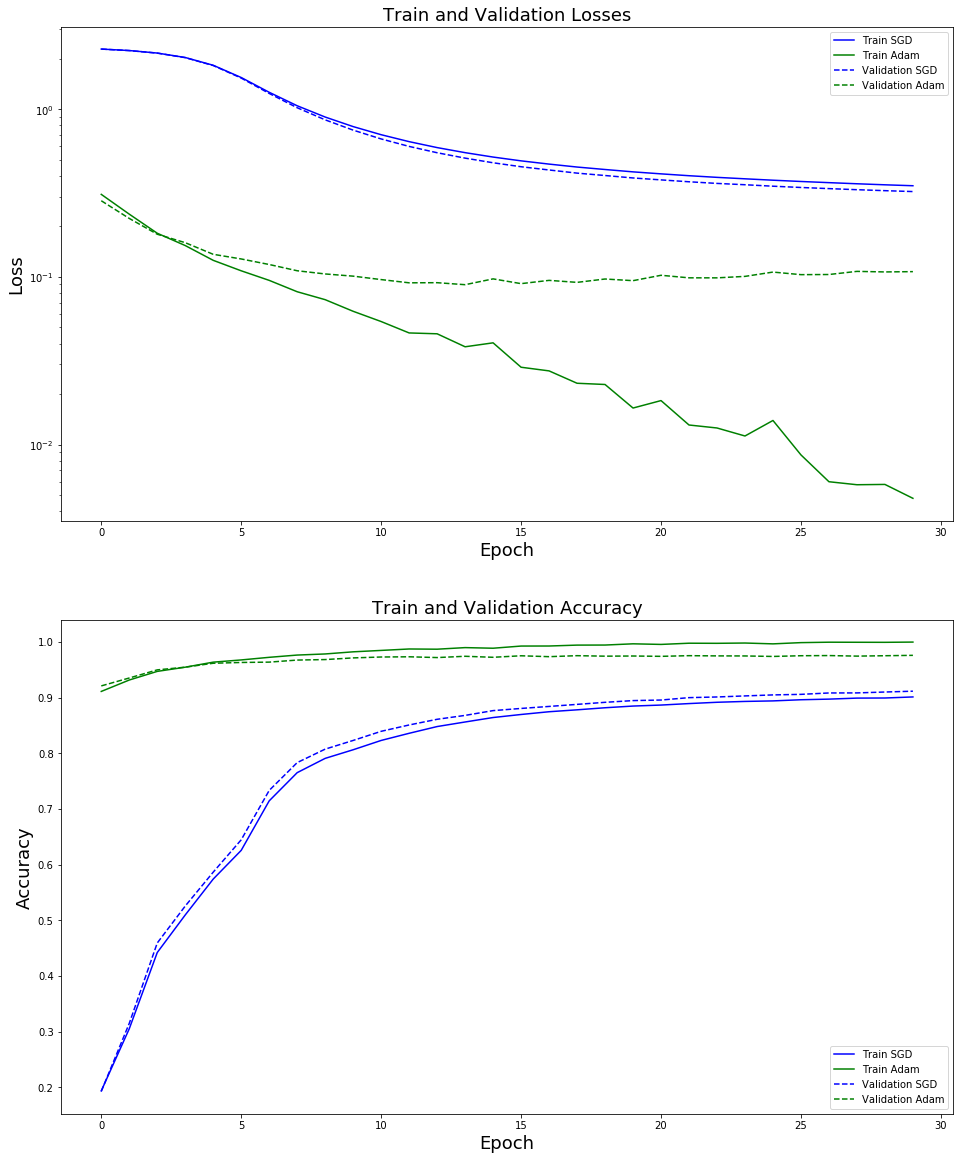

Epoch 30
Min train losses: SGD 0.3489; Adam 0.004778
Min val losses: SGD 0.3221; Adam 0.0897
Max train accuracy: SGD 0.9011; Adam 0.9996
Max val accuracy: SGD 0.9114; Adam 0.9758
Times: SGD 34.56 sec; Adam 39.72 sec


In [19]:
# Your code goes here. ################################################
sgd_relu_net = Sequential()
sgd_relu_net.add(Linear(X_train.shape[1], 100))
sgd_relu_net.add(ReLU())
sgd_relu_net.add(Linear(100, 200))
sgd_relu_net.add(ReLU())
sgd_relu_net.add(Linear(200, 10))
sgd_relu_net.add(LogSoftMax())
sgd_relu_criterion = ClassNLLCriterion()

adam_relu_net = Sequential()
adam_relu_net.add(Linear(X_train.shape[1], 100))
adam_relu_net.add(ReLU())
adam_relu_net.add(Linear(100, 200))
adam_relu_net.add(ReLU())
adam_relu_net.add(Linear(200, 10))
adam_relu_net.add(LogSoftMax())
adam_relu_criterion = ClassNLLCriterion()

sgd_relu_val_loss_history = []
adam_relu_val_loss_history = []

sgd_relu_train_loss_history = []
adam_relu_train_loss_history = []

sgd_relu_val_accuracy_history = []
adam_relu_val_accuracy_history = []

sgd_relu_train_accuracy_history = []
adam_relu_train_accuracy_history = []

sgd_relu_time = 0
adam_relu_time = 0

adam_relu_optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
adam_relu_optimizer_state = {}
sgd_relu_optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
sgd_relu_optimizer_state = {}

n_epoch = 30
batch_size = 500
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        sgd_relu_start_time = time()
        sgd_relu_net.zeroGradParameters()
        sgd_relu_predictions = sgd_relu_net.forward(x_batch)
        sgd_relu_loss = sgd_relu_criterion.forward(sgd_relu_predictions, y_batch)
        sgd_relu_dp = sgd_relu_criterion.backward(sgd_relu_predictions, y_batch)
        sgd_relu_net.backward(x_batch, sgd_relu_dp)
        sgd_momentum(sgd_relu_net.getParameters(), 
                     sgd_relu_net.getGradParameters(), 
                     sgd_relu_optimizer_config,
                     sgd_relu_optimizer_state)
        sgd_relu_stop_time = time()
        sgd_relu_time += sgd_relu_stop_time - sgd_relu_start_time
        
        adam_relu_start_time = time()
        adam_relu_net.zeroGradParameters()
        adam_relu_predictions = adam_relu_net.forward(x_batch)
        adam_relu_loss = adam_relu_criterion.forward(adam_relu_predictions, y_batch)
        adam_relu_dp = adam_relu_criterion.backward(adam_relu_predictions, y_batch)
        adam_relu_net.backward(x_batch, adam_relu_dp)
        adam_optimizer(adam_relu_net.getParameters(),
                       adam_relu_net.getGradParameters(), 
                       adam_relu_optimizer_config,
                       adam_relu_optimizer_state)
        adam_relu_stop_time = time()
        adam_relu_time += adam_relu_stop_time - adam_relu_start_time
        

    # Validation scores and losses
    sgd_relu_val_predictions = sgd_relu_net.forward(X_val)
    sgd_relu_val_loss = sgd_relu_criterion.forward(sgd_relu_val_predictions, y_val)
    sgd_relu_val_accuracy = get_accuracy(y_val, sgd_relu_val_predictions)
    adam_relu_val_predictions = adam_relu_net.forward(X_val)
    adam_relu_val_loss = adam_relu_criterion.forward(adam_relu_val_predictions, y_val)
    adam_relu_val_accuracy = get_accuracy(y_val, adam_relu_val_predictions)
    
    
    sgd_relu_val_loss_history.append(sgd_relu_val_loss)
    adam_relu_val_loss_history.append(adam_relu_val_loss)
    
    sgd_relu_val_accuracy_history.append(sgd_relu_val_accuracy)
    adam_relu_val_accuracy_history.append(adam_relu_val_accuracy)
    
    #Train scores and losses
    sgd_relu_train_predictions = sgd_relu_net.forward(X_train)
    sgd_relu_train_loss = sgd_relu_criterion.forward(sgd_relu_train_predictions, y_train)
    sgd_relu_train_accuracy = get_accuracy(y_train, sgd_relu_train_predictions)
    adam_relu_train_predictions = adam_relu_net.forward(X_train)
    adam_relu_train_loss = adam_relu_criterion.forward(adam_relu_train_predictions, y_train)
    adam_relu_train_accuracy = get_accuracy(y_train, adam_relu_train_predictions)
    
    
    sgd_relu_train_loss_history.append(sgd_relu_train_loss)
    adam_relu_train_loss_history.append(adam_relu_train_loss)
    
    sgd_relu_train_accuracy_history.append(sgd_relu_train_accuracy)
    adam_relu_train_accuracy_history.append(adam_relu_train_accuracy)
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(16, 20))
    plt.subplot(2, 1, 1)
    plt.title("Train and Validation Losses", fontsize=18)
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Loss", fontsize=18)
    plt.semilogy(sgd_relu_train_loss_history, 'b', label='Train SGD')
    plt.semilogy(adam_relu_train_loss_history, 'g', label='Train Adam')
    plt.semilogy(sgd_relu_val_loss_history, 'b', label='Validation SGD', linestyle='--')
    plt.semilogy(adam_relu_val_loss_history, 'g', label='Validation Adam', linestyle='--')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.title("Train and Validation Accuracy", fontsize=18)
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Accuracy", fontsize=18)
    plt.plot(sgd_relu_train_accuracy_history, 'b', label='Train SGD')
    plt.plot(adam_relu_train_accuracy_history, 'g', label='Train Adam')
    plt.plot(sgd_relu_val_accuracy_history, 'b', label='Validation SGD', linestyle='--')
    plt.plot(adam_relu_val_accuracy_history, 'g', label='Validation Adam', linestyle='--')
    plt.legend()
    plt.show()
    
    print('Epoch {}'.format(i+1))
    print('Min train losses: SGD {:.4}; Adam {:.4}'.
          format(min(sgd_relu_train_loss_history), min(adam_relu_train_loss_history)))
    print('Min val losses: SGD {:.4}; Adam {:.4}'.
          format(min(sgd_relu_val_loss_history), min(adam_relu_val_loss_history)))
    print('Max train accuracy: SGD {:.4}; Adam {:.4}'.
          format(max(sgd_relu_train_accuracy_history), max(adam_relu_train_accuracy_history))) 
    print('Max val accuracy: SGD {:.4}; Adam {:.4}'.
          format(max(sgd_relu_val_accuracy_history), max(adam_relu_val_accuracy_history)))
    print('Times: SGD {:.4} sec; Adam {:.4} sec'.
          format(sgd_relu_time, adam_relu_time))

From the plots above one can seen that Adam outperforms SGD. Moreover Adam converges much faster than SGD and finds better optimum faster so it shows better accuracy scores on both training and validation sets.

4. **Dropout layer**

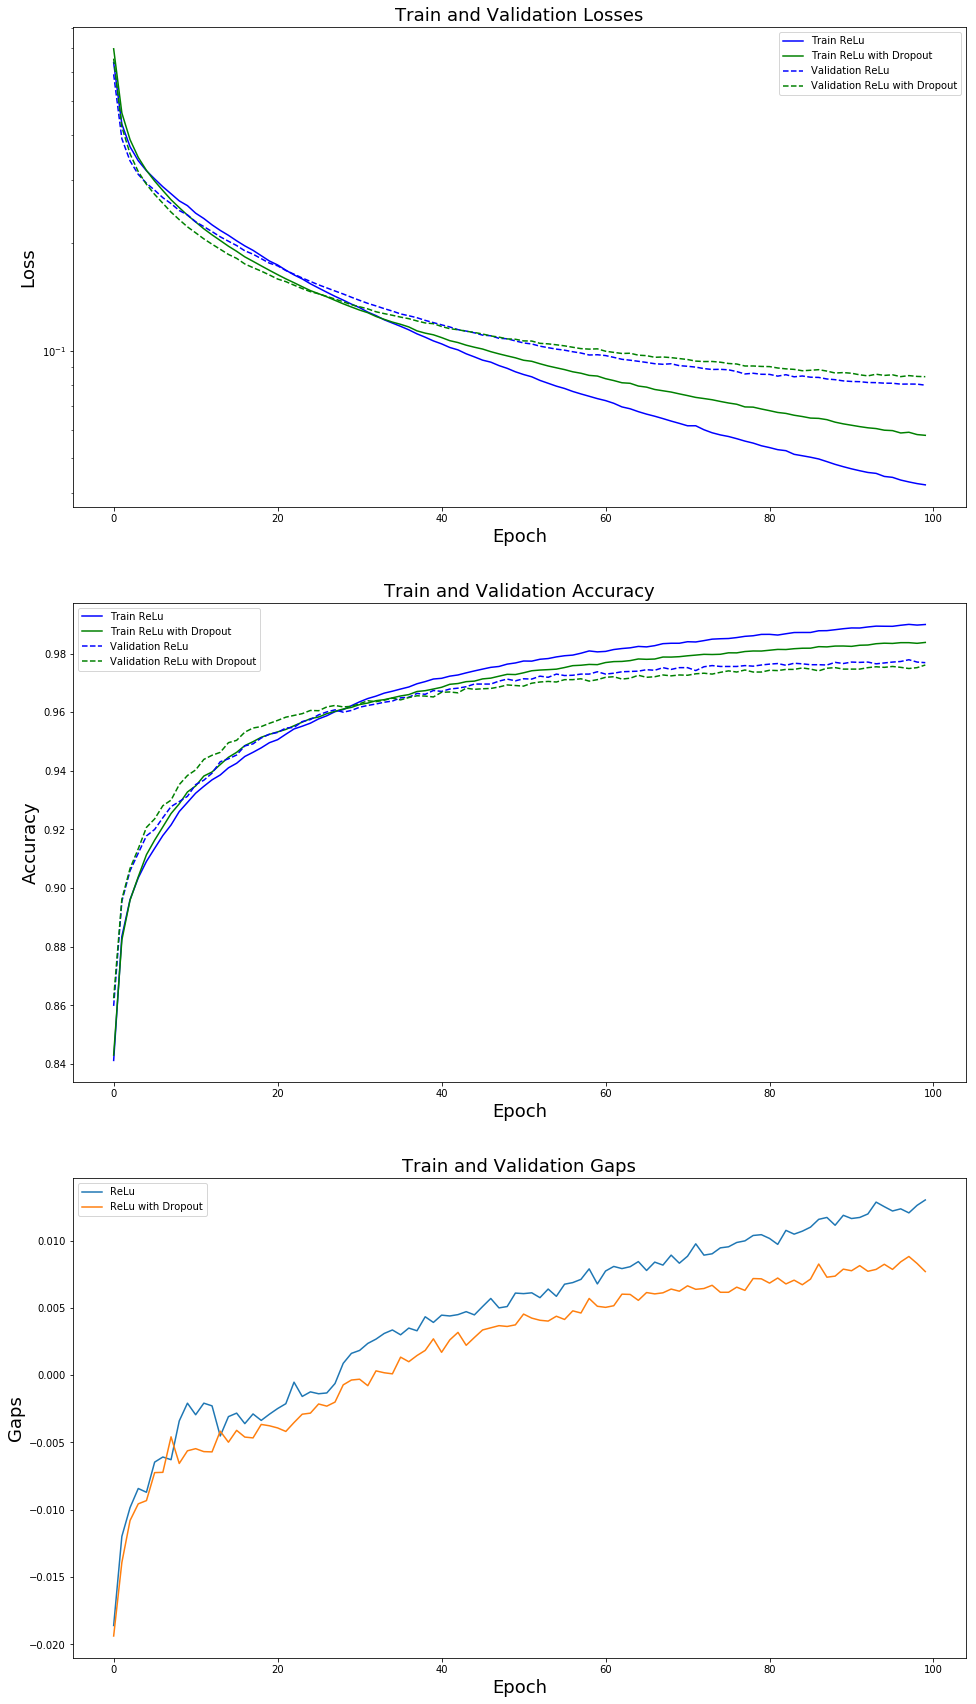

Epoch 100
Min train losses: ReLu 0.04219; Dropout 0.05803
Min val losses: ReLu 0.08013; Dropout 0.08463
Max train accuracy: ReLu 0.99; Dropout 0.9838
Max val accuracy: ReLu 0.9779; Dropout 0.9761
Times: ReLu 167.7 sec; Dropout 215.8 sec


In [20]:
# Your code goes here. ################################################
relu_net = Sequential()
relu_net.add(Linear(X_train.shape[1], 200))
relu_net.add(ReLU())
relu_net.add(Linear(200, 10))
relu_net.add(LogSoftMax())
relu_criterion = ClassNLLCriterion()

drop_relu_net = Sequential()
drop_relu_net.add(Linear(X_train.shape[1], 200))
drop_relu_net.add(ReLU())
drop_relu_net.add(Dropout(p=0.6))
drop_relu_net.add(Linear(200, 10))
drop_relu_net.add(LogSoftMax())
drop_relu_criterion = ClassNLLCriterion()

relu_val_loss_history = []
drop_relu_val_loss_history = []

relu_train_loss_history = []
drop_relu_train_loss_history = []

relu_val_accuracy_history = []
drop_relu_val_accuracy_history = []

relu_train_accuracy_history = []
drop_relu_train_accuracy_history = []

relu_time = 0
drop_relu_time = 0

relu_optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
# {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
relu_optimizer_state = {}
drop_relu_optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
drop_relu_optimizer_state = {}

relu_gap_history = []
drop_relu_gap_history = []

n_epoch = 100
batch_size = 500
for i in range(n_epoch):
    relu_net.train()
    drop_relu_net.train()
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        relu_start_time = time()
        relu_net.zeroGradParameters()
        relu_predictions = relu_net.forward(x_batch)
        relu_loss = relu_criterion.forward(relu_predictions, y_batch)
        relu_dp = relu_criterion.backward(relu_predictions, y_batch)
        relu_net.backward(x_batch, relu_dp)
        sgd_momentum(relu_net.getParameters(), 
                     relu_net.getGradParameters(), 
                     relu_optimizer_config,
                     relu_optimizer_state)
        relu_stop_time = time()
        relu_time += relu_stop_time - relu_start_time
        
        drop_relu_start_time = time()
        drop_relu_net.zeroGradParameters()
        drop_relu_predictions = drop_relu_net.forward(x_batch)
        drop_relu_loss = drop_relu_criterion.forward(drop_relu_predictions, y_batch)
        drop_relu_dp = drop_relu_criterion.backward(drop_relu_predictions, y_batch)
        drop_relu_net.backward(x_batch, drop_relu_dp)
        sgd_momentum(drop_relu_net.getParameters(), 
                     drop_relu_net.getGradParameters(), 
                     drop_relu_optimizer_config,
                     drop_relu_optimizer_state)
        drop_relu_stop_time = time()
        drop_relu_time += drop_relu_stop_time - drop_relu_start_time
        

    # Validation scores and losses
    relu_net.evaluate()
    drop_relu_net.evaluate()
    
    relu_val_predictions = relu_net.forward(X_val)
    relu_val_loss = relu_criterion.forward(relu_val_predictions, y_val)
    relu_val_accuracy = get_accuracy(y_val, relu_val_predictions)
    drop_relu_val_predictions = drop_relu_net.forward(X_val)
    drop_relu_val_loss = drop_relu_criterion.forward(drop_relu_val_predictions, y_val)
    drop_relu_val_accuracy = get_accuracy(y_val, drop_relu_val_predictions)
    
    
    relu_val_loss_history.append(relu_val_loss)
    drop_relu_val_loss_history.append(drop_relu_val_loss)
    
    relu_val_accuracy_history.append(relu_val_accuracy)
    drop_relu_val_accuracy_history.append(drop_relu_val_accuracy)
    
    #Train scores and losses
    relu_train_predictions = relu_net.forward(X_train)
    relu_train_loss = relu_criterion.forward(relu_train_predictions, y_train)
    relu_train_accuracy = get_accuracy(y_train, relu_train_predictions)
    drop_relu_train_predictions = drop_relu_net.forward(X_train)
    drop_relu_train_loss = drop_relu_criterion.forward(drop_relu_train_predictions, y_train)
    drop_relu_train_accuracy = get_accuracy(y_train, drop_relu_train_predictions)
    
    
    relu_train_loss_history.append(relu_train_loss)
    drop_relu_train_loss_history.append(drop_relu_train_loss)
    
    relu_train_accuracy_history.append(relu_train_accuracy)
    drop_relu_train_accuracy_history.append(drop_relu_train_accuracy)
    
    relu_gap_history.append(relu_train_accuracy - relu_val_accuracy)
    drop_relu_gap_history.append(drop_relu_train_accuracy - drop_relu_val_accuracy)
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(16, 30))
    plt.subplot(3, 1, 1)
    plt.title("Train and Validation Losses", fontsize=18)
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Loss", fontsize=18)
    plt.semilogy(relu_train_loss_history, 'b', label='Train ReLu')
    plt.semilogy(drop_relu_train_loss_history, 'g', label='Train ReLu with Dropout')
    plt.semilogy(relu_val_loss_history, 'b', label='Validation ReLu', linestyle='--')
    plt.semilogy(drop_relu_val_loss_history, 'g', label='Validation ReLu with Dropout', linestyle='--')
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.title("Train and Validation Accuracy", fontsize=18)
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Accuracy", fontsize=18)
    plt.plot(relu_train_accuracy_history, 'b', label='Train ReLu')
    plt.plot(drop_relu_train_accuracy_history, 'g', label='Train ReLu with Dropout')
    plt.plot(relu_val_accuracy_history, 'b', label='Validation ReLu', linestyle='--')
    plt.plot(drop_relu_val_accuracy_history, 'g', label='Validation ReLu with Dropout', linestyle='--')
    plt.legend()
    
    plt.subplot(3, 1, 3)
    plt.title("Train and Validation Gaps", fontsize=18)
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Gaps", fontsize=18)
    plt.plot(relu_gap_history, label='ReLu')
    plt.plot(drop_relu_gap_history, label='ReLu with Dropout')
    plt.legend()
    
    plt.show()
    
    print('Epoch {}'.format(i+1))
    print('Min train losses: ReLu {:.4}; Dropout {:.4}'.
          format(min(relu_train_loss_history), min(drop_relu_train_loss_history)))
    print('Min val losses: ReLu {:.4}; Dropout {:.4}'.
          format(min(relu_val_loss_history), min(drop_relu_val_loss_history)))
    print('Max train accuracy: ReLu {:.4}; Dropout {:.4}'.
          format(max(relu_train_accuracy_history), max(drop_relu_train_accuracy_history))) 
    print('Max val accuracy: ReLu {:.4}; Dropout {:.4}'.
          format(max(relu_val_accuracy_history), max(drop_relu_val_accuracy_history)))
    print('Times: ReLu {:.4} sec; Dropout {:.4} sec'.
          format(relu_time, drop_relu_time))

Dropout prevent network from overfitting. On the 'Train and Validation Gaps' figure one can see that the gap between train and validation scores are lower for the network with Dropout than the network without Dropout.

At the same time the quality on validation set for both networks is quite similar. This happens because here we have very simple dataset MNIST and the network without Dropout doesn't overfit too much. So the difference in validation scores is not seen clearly. However in case of complicated dataset and deep networks Dropout will show far more signifficant increase in validation score.

# Learning embeddings

**Finally**, use the Contrastive criterion instead of the NLLCriterion to train the embeddings. 
Using the code below, compute the pairwise distances and show the distance histograms for the validation set (or its part). Compute the Bhattacharyya coefficient using the outputs of the plt.hist: $ BC(p,q) = \sum (\sqrt{p_i q_i}) $.

Repeat this for the embeddings trained with the NLLCriterion, compare the results. You may want to try different margins $M$ (hint: $M=10$ should be okay).

 ***3 points***

In [42]:
#features : 'number of examples' * 'dimensionality'
#<YOUR CODE GOES HERE>
contr_net = Sequential()
contr_net.add(Linear(X_train.shape[1], 100))
contr_net.add(ReLU())
contr_net.add(Linear(100, 10))
contr_criterion = ClassContrastiveCriterion(10)

nll_net = Sequential()
nll_net.add(Linear(X_train.shape[1], 100))
nll_net.add(ReLU())
nll_net.add(Linear(100, 10))
nll_net.add(LogSoftMax())
nll_criterion = ClassNLLCriterion()

contr_optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
contr_optimizer_state = {}
# contr_time = 0
nll_optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
nll_optimizer_state = {}
# nll_time = 0

n_epoch = 10
batch_size = 50
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train_orig), batch_size):
        
        contr_net.zeroGradParameters()
        contr_embeds = contr_net.forward(x_batch)
        contr_loss = contr_criterion.forward(contr_embeds, y_batch)
        contr_dp = contr_criterion.backward(contr_embeds, y_batch)
        contr_net.backward(x_batch, contr_dp)
        sgd_momentum(contr_net.getParameters(), 
                     contr_net.getGradParameters(), 
                     contr_optimizer_config,
                     contr_optimizer_state)

        y_batch_encoded = one_hot_encode(y_batch, 10)
        nll_net.zeroGradParameters()
        nll_predictions = nll_net.forward(x_batch)
        nll_loss = nll_criterion.forward(nll_predictions, y_batch_encoded)
        nll_dp = nll_criterion.backward(nll_predictions, y_batch_encoded)
        nll_net.backward(x_batch, nll_dp)
        sgd_momentum(nll_net.getParameters(), 
                     nll_net.getGradParameters(), 
                     nll_optimizer_config,
                     nll_optimizer_state)
    print('Epoch {}'.format(i+1))
    
contr_net.forward(X_val)
nll_net.forward(X_val)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


array([[-1.95739995e+01, -1.02125724e+01, -9.88619807e+00, ...,
        -2.10762742e+01, -1.16137350e+01, -1.71951017e+01],
       [-1.41504848e+01, -1.29345361e+01, -8.99266711e+00, ...,
        -1.41330820e+01, -2.21603027e-03, -1.11724321e+01],
       [-5.81358038e+00, -9.58850611e+00, -5.61819019e+00, ...,
        -8.17784099e+00, -1.40553603e+01, -1.05277000e+01],
       ...,
       [-1.70794708e+01, -1.64103008e+01, -2.32907574e+01, ...,
        -1.90195522e+01, -1.37540886e+01, -1.15833711e+01],
       [-6.82309950e+00, -9.58120656e+00, -6.74907082e+00, ...,
        -1.09011530e+01, -1.32075451e+01, -1.17321644e+01],
       [-4.79189578e+00, -1.26059304e+01, -8.46418484e+00, ...,
        -8.20388204e+00, -1.13140207e-02, -6.07846362e+00]])

For network with Contrastive criterion:
5006741.0 44988259.0
bhattacharyya = 0.4177910884056471


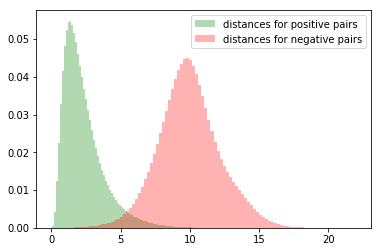

In [43]:
f = contr_net.modules[-1].output

import scipy.spatial
#compute pairwise distances
d = scipy.spatial.distance_matrix(f, f)
#extract distances for the 'positive pairs' (same class), 
#extract distances for the 'negarite pairs' (different classes), 
labels = y_val_orig
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b =np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
#labels
c = np.zeros((len(labels), len(labels)))
c[a==b]=1
pind = np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a!=b]=1
nind =  np.triu(c, k=1)

print('For network with Contrastive criterion:')
print(np.sum(pind), np.sum(nind))


pd = d[pind == 1]
nd = d[nind == 1]

hp,_,_ =plt.hist(pd, bins=100, color='green', alpha = 0.3, weights = np.ones(len(pd))/len(pd), label = 'distances for positive pairs')
hn,_,_ =plt.hist(nd, bins=100, color='red', alpha = 0.3, weights = np.ones(len(nd))/len(nd),label = 'distances for negative pairs')
plt.legend(loc='best')

bhattacharyya = np.sum(np.sqrt(hp*hn))
print('bhattacharyya = {}'.format(bhattacharyya))

For network with NLLCriterion: 
5006741.0 44988259.0
bhattacharyya = 0.7580418943598994


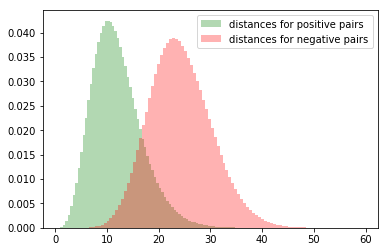

In [44]:
f = nll_net.modules[-2].output

import scipy.spatial
#compute pairwise distances
d = scipy.spatial.distance_matrix(f, f)
#extract distances for the 'positive pairs' (same class), 
#extract distances for the 'negarite pairs' (different classes), 
labels = y_val_orig
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b =np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
#labels
c = np.zeros((len(labels), len(labels)))
c[a==b]=1
pind = np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a!=b]=1
nind =  np.triu(c, k=1)

print('For network with NLLCriterion: ')
print(np.sum(pind), np.sum(nind))


pd = d[pind == 1]
nd = d[nind == 1]

hp,_,_ =plt.hist(pd, bins=100, color='green', alpha = 0.3, weights = np.ones(len(pd))/len(pd), label = 'distances for positive pairs')
hn,_,_ =plt.hist(nd, bins=100, color='red', alpha = 0.3, weights = np.ones(len(nd))/len(nd),label = 'distances for negative pairs')
plt.legend(loc='best')

bhattacharyya = np.sum(np.sqrt(hp*hn))
print('bhattacharyya = {}'.format(bhattacharyya))

The usage of Contrastive criterion indeed helped to separate distributions. The mean of negative ones are shifted to the margin value while the mean of positive ones are shifted to the zero. The usage of NLL criterion does it worse which can be seen on Bhattacharyya coefficients for both nets: 0.42 vs 0.76.